In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

load_dotenv()

True

In [2]:
def get_llm():
    return ChatOpenAI(temperature=0, model="gpt-4o-mini")

def get_embeddings():
    return OpenAIEmbeddings()

: 

#### Creating VectorDatabase

In [3]:
from langchain.schema import Document
from langchain_community.vectorstores import Chroma

embedding_function = get_embeddings()

docs = [
    Document(
        page_content="Elon musk is found of tesla. he was born",
        metadata={"source": "elon_musk.txt"},
    ),

]

db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever()

In [ ]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    question: str
    grades: list[str]
    llm_output: str
    documents: list[str]
    on_topic: bool
    past_convo: str

In [ ]:
def retrieve_docs(state: AgentState):
    question = state["question"]
    documents = retriever.get_relevant_documents(query=question)
    print("RETRIEVED DOCUMENTS:", documents)
    state["documents"] = [doc.page_content for doc in documents]
    return state

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is releated to the grave model person"""

    score: str = Field(
        description="Question is about (User)? If yes -> 'Yes' if not -> 'No'"
    )


def question_classifier(state: AgentState):
    question = state["question"]
    past_convo = "This is the past conversation: " + str(state["past_convo"])

    system = """You are a grader assessing the topic a user question. \n
        Only answer if the question is about one of the following topics:
        1. Information about the person (User Name)
        2. Past Conversations
        3. other 2
        4. other

        Examples: How will the weather be today -> No
                  Is (User) still alive -> Yes
                  What was (User) most humble moment -> Yes

        If the question IS about these topics response with "Yes", otherwise respond with "No".
        """

    system = system + past_convo

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = get_llm()
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    print(f"QUESTION and GRADE: {question} - {result.score}")
    state["on_topic"] = result.score
    return state

In [ ]:
def on_topic_router(state: AgentState):
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"

In [ ]:
def off_topic_response(state: AgentState):
    state["llm_output"] = "I cant respond to that!"
    return state

In [ ]:
class GradeDocuments(BaseModel):
    """Boolean values to check for relevance on retrieved documents."""

    score: str = Field(
        description="Documents are relevant to the question, 'Yes' or 'No'"
    )


def document_grader(state: AgentState):
    docs = state["documents"]
    question = state["question"]

    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Retrieved document: \n\n {document} \n\n User question: {question}",
            ),
        ]
    )

    llm = get_llm()
    structured_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structured_llm
    scores = []
    for doc in docs:
        result = grader_llm.invoke({"document": doc, "question": question})
        scores.append(result.score)
    state["grades"] = scores
    return state

In [ ]:
def gen_router(state: AgentState):
    grades = state["grades"]
    print("DOCUMENT GRADES:", grades)

    if any(grade.lower() == "yes" for grade in grades):
        filtered_grades = [grade for grade in grades if grade.lower() == "yes"]
        print("FILTERED DOCUMENT GRADES:", filtered_grades)
        return "generate"
    else:
        return "rewrite_query"

In [ ]:
from langchain_core.output_parsers import StrOutputParser


def rewriter(state: AgentState):
    question = state["question"]
    system = """You a question re-writer that converts an input question to a better version that is optimized \n
        for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. If needed use past conversation."""
    past_convo = "This is the past conversation: " + str(state["past_convo"])
    system = system + past_convo

    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    llm = get_llm()
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({"question": question})
    state["question"] = output
    return state

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

def generate_answer(state: AgentState):
    llm = get_llm()
    question = state["question"]
    context = state["documents"]
    past_convo = state["past_convo"]
    

    template = """Answer the question based only on the following context or past conversations.:
    {context}
    Past Conversation: {past_convo}
    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(
        template=template,
    )

    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question, "context": context, "past_convo": past_convo})
    state["llm_output"] = result
    return state

In [ ]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("rewrite_query", rewriter)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("document_grader", document_grader)

workflow.add_edge("off_topic_response", END)
workflow.add_edge("retrieve_docs", "document_grader")
workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response",
    },
)
workflow.add_conditional_edges(
    "document_grader",
    gen_router,
    {
        "generate": "generate_answer",
        "rewrite_query": "rewrite_query",
    },
)
workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)


workflow.set_entry_point("topic_decision")

app = workflow.compile()

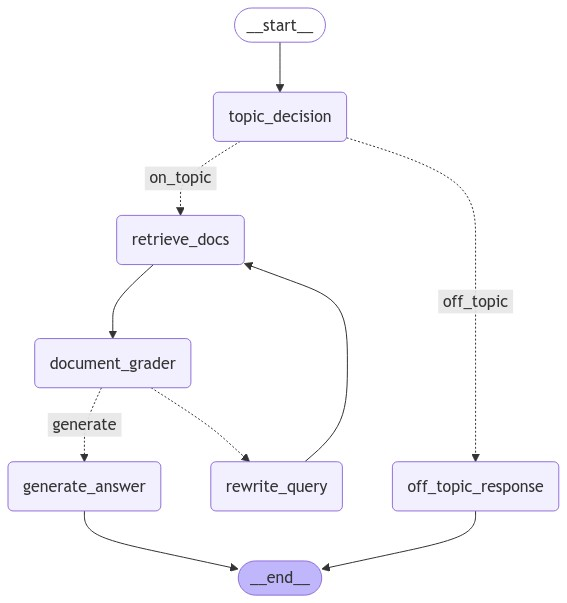

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [5]:
past_convo = """

User: How is the weather?
Bot: I can't respond to that!

User: Who is the owner of bella vista?
Bot: The owner of Bella Vista is Antonio Rossi.
User: My name is Kgen.
Bot: Nice, how are you Kgen?
User: I am fine. Thanks for asking.
"""
result = app.invoke({"question": "How is the weather?", "past_convo": past_convo})
result["llm_output"]


NameError: name 'app' is not defined

In [ ]:
result = app.invoke({"question": "Who is the owner of bella vista?"})
result["llm_output"]

QUESTION and GRADE: Who is the owner of bella vista? - Yes
RETRIEVED DOCUMENTS: [Document(metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.'), Document(metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.'), Document(metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.'), Document(metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended fro

'The owner of Bella Vista is Antonio Rossi.'